# Difc calculation using scipy


In [1]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import os, numpy as np
from mantid import simpleapi as msa, mtd

In [3]:
dvalues = [1.10860231, 1.24596143, 1.357755, 1.63751414, 1.92015553, 3.13560085]

In [4]:
%%time
ws = msa.Load('/SNS/SEQ/IPTS-19573/nexus/SEQ_130273.nxs.h5')

CPU times: user 1min 2s, sys: 16.5 s, total: 1min 18s
Wall time: 15.4 s


In [5]:
%%time
ws = msa.CropWorkspace(InputWorkspace=ws, XMin=300, XMax=16666.7)

CPU times: user 3min 39s, sys: 3min 3s, total: 6min 43s
Wall time: 27.1 s


## Compute nominal difc

In [6]:
difc = msa.CalculateDIFC(InputWorkspace=ws)

In [7]:
difc = difc.extractY().flatten()

# Use nominal values to convert to I(d)

In [8]:
%%time
I_d = msa.ConvertUnits(InputWorkspace=ws, Target='dSpacing', EMode='Elastic')

CPU times: user 10 s, sys: 8.45 s, total: 18.5 s
Wall time: 18.5 s


In [12]:
%%time
I_d = msa.Rebin(InputWorkspace=I_d, Params='0.4,0.01,7')

CPU times: user 132 ms, sys: 4 ms, total: 136 ms
Wall time: 134 ms


In [13]:
I_d_100455 = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=100455, EndWorkspaceIndex=100455)

<IPython.core.display.Javascript object>


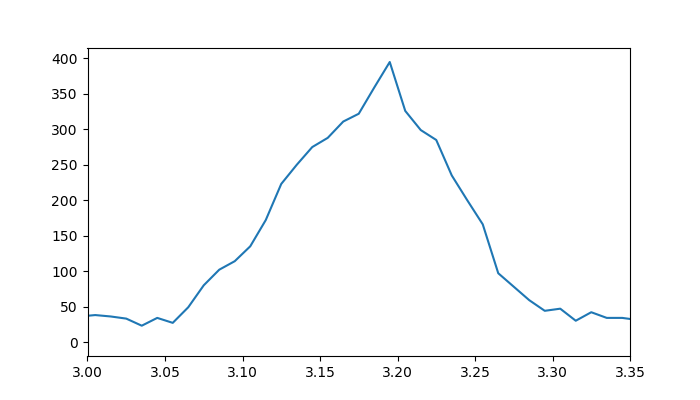

(3, 3.35)

In [87]:
plt.figure(figsize=(7,4))
Xbb = I_d_100455.readX(0)
plt.plot( (Xbb[:-1]+Xbb[1:])/2, I_d_100455.readY(0))
plt.xlim(3,3.35)

Simple fitting

In [15]:
import scipy.optimize as sopt

In [88]:
x = (Xbb[:-1]+Xbb[1:])/2
y = I_d_100455.readY(0)

In [89]:
np.where(x>3)[0][0], np.where(x<3.3)[0][-1]

(260, 289)

In [90]:
x1 = x[260:289]
y1 = y[260:289]

<IPython.core.display.Javascript object>


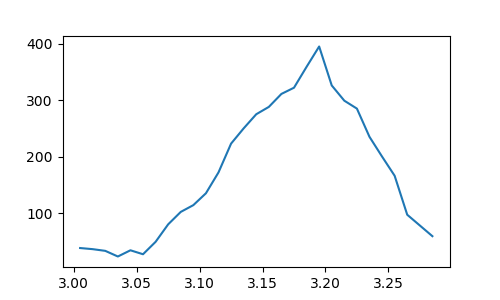

In [91]:
plt.figure(figsize=(5,3))
plt.plot(x1,y1)

In [19]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [84]:
def gauss_with_bg(x, *p):
    A, mu, sigma, bg = p
    return bg + A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [92]:
popt, pcov = sopt.curve_fit(gauss_with_bg, x1, y1, p0=(400, 3.13, 0.05, 0))
print popt

[  3.30132879e+02   3.18342033e+00   5.31202012e-02   2.46274639e+01]


obsolete
```
def cost(p):
    y1_model = gauss(x1, *p)
    return np.sum( (y1-y1_model)**2 )

optres = sopt.minimize(cost, x0=(400, 3.13, 0.05))

optres.x
```

<IPython.core.display.Javascript object>


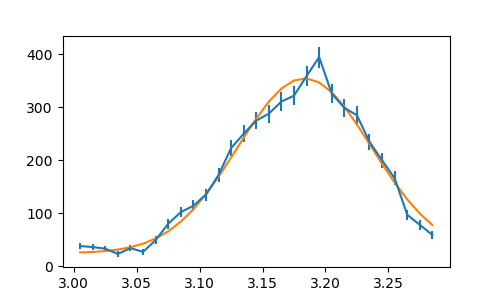

In [94]:
plt.figure(figsize=(5,3))
plt.errorbar(x1, y1, yerr=np.sqrt(y1))
plt.plot(x1, gauss_with_bg(x1, *popt))

goodness of fit?

In [95]:
chisq = np.average((y1 - gauss_with_bg(x1, *popt))**2 / y1)

In [96]:
chisq

2.1147544856024143

In [97]:
difc[100455]

2023.9221907717592

new difc

In [98]:
difc[100455]*optres.x[1]/3.13560085

2054.3365999208204

## Loop over all pixels in D23

In [58]:
N = I_d.getNumberHistograms()

In [126]:
newdifc = difc.copy()

In [127]:
mask = np.zeros(difc.shape, dtype=bool)
chisq = np.zeros(difc.shape, dtype=float)

In [128]:
firstindex = 100352
lastindex = 101375

In [129]:
%%time
d_target = 3.13560085
for pixel in range(firstindex, lastindex+1):
    if (pixel%100)==0 : print pixel
    I_d_pixel = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=pixel, EndWorkspaceIndex=pixel)
    Xbb = I_d_pixel.readX(0)
    x = (Xbb[:-1]+Xbb[1:])/2
    y = I_d_pixel.readY(0)
    startindex, stopindex = np.where(x>2.8)[0][0], np.where(x<3.5)[0][-1]
    x1 = x[startindex:stopindex]
    y1 = y[startindex:stopindex]
    p0 = np.max(y1), x1[np.argmax(y1)], 0.1, 0
    try:
        popt, pcov = sopt.curve_fit(gauss_with_bg, x1, y1, p0=p0)
    except:
        mask[pixel] = 1
        continue
    chisq[pixel] = np.average((y1 - gauss_with_bg(x1, *popt))**2 / y1)
    center = popt[1]
    newdifc[pixel] = difc[pixel] * center / d_target
    continue

/home/lj7/miniconda2/envs/mantid/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in divide


100400


/home/lj7/miniconda2/envs/mantid/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in divide


100500
100600
100700
100800
100900
101000
101100
101200
101300
CPU times: user 11.8 s, sys: 2.95 s, total: 14.7 s
Wall time: 11.3 s


In [130]:
chisq_d23 = chisq[firstindex:lastindex+1]
chisq_d23.shape = 8, 128
chisq_d23

array([[  0.,  inf,  inf, ...,  inf,  inf,  inf],
       [ nan,  inf,  inf, ...,  inf,  inf,  nan],
       [ inf,  inf,  inf, ...,  inf,  inf,  inf],
       ..., 
       [ nan,  inf,  inf, ...,  inf,  inf,  inf],
       [ nan,   0.,  inf, ...,  inf,  inf,  inf],
       [ nan,  inf,  inf, ...,  inf,  nan,  nan]])

In [131]:
chisq_d23[np.logical_not( np.isinf(chisq_d23) )]

array([ 0.        ,  1.25613055,  1.40583566,  0.92932938,  1.74930189,
        1.60014082,  1.9125223 ,  1.51820389,  1.01534275,  1.22178233,
        0.95689665,  1.15700046,  1.18401267,  1.23194821,  0.92185499,
        1.12089806,  1.57003457,  0.96148817,  0.97881957,  1.40680515,
        0.93840241,  1.19043401,  2.28838418,  1.61926504,  1.71388982,
        1.14548896,  1.27168356,  1.12789666,  1.09266695,  1.7244095 ,
        1.32057354,  1.19437664,  1.57301534,  1.23292456,  2.30280502,
        1.73307509,  1.83492148,  2.41390982,  1.21591029,  1.98438312,
        1.75750344,  3.68380081,  2.29428844,  1.35698573,  1.97820235,
        1.9907441 ,  1.5050929 ,  3.20469227,  1.6566307 ,  1.68825491,
        2.6481109 ,  1.81182076,  2.73197349,  1.83132779,  2.25434345,
        2.28821305,  2.7421344 ,  2.88821625,  2.78215134,  2.33136379,
        2.08920936,  2.46869341,  2.2183419 ,  2.3285615 ,  2.65845595,
        2.08067476,  2.38484683,  2.52315476,  2.07111636,  2.78

In [132]:
np.max(chisq_d23[np.isfinite(chisq_d23)])

3.8035445810431452

In [133]:
np.where(chisq_d23 == np.max(chisq_d23[np.isfinite(chisq_d23)]))

(array([2]), array([121]))

In [134]:
firstindex + 2*128+121

100729

In [111]:
firstindex + 4*128+18

100882

In [162]:
mask[np.logical_not(np.isfinite(chisq))] = 1

In [163]:
np.save('difc-2-D23-mask.npy', mask)

In [165]:
np.save('difc-2-D23-difc.npy', newdifc)

# Check 100729

In [135]:
I_d_100729 = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=100729, EndWorkspaceIndex=100729)

In [136]:
Xbb = I_d_100729.readX(0)
Y = I_d_100729.readY(0)

In [137]:
X = (Xbb[1:] + Xbb[:-1])/2

<IPython.core.display.Javascript object>


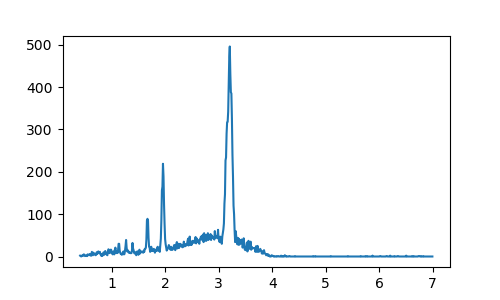

In [138]:
plt.figure(figsize=(5,3))
plt.plot(X,Y)
# plt.xlim(3, 3.5)

In [139]:
startindex, stopindex = np.where(X>2.8)[0][0], np.where(X<3.5)[0][-1]
X1 = X[startindex:stopindex]
Y1 = Y[startindex:stopindex]

<IPython.core.display.Javascript object>


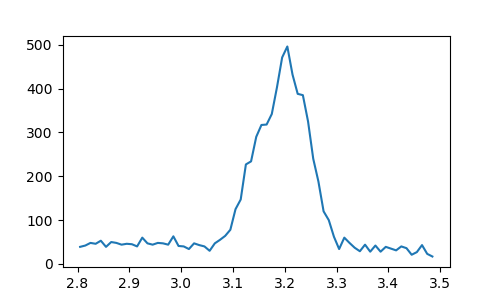

In [140]:
plt.figure(figsize=(5,3))
plt.plot(X1,Y1)

In [141]:
popt, pcov = sopt.curve_fit(gauss_with_bg, X1, Y1, p0=(400, 3.13, 0.05, 0))
print popt

[  4.13256309e+02   3.19789048e+00   4.84076210e-02   3.86891537e+01]


<IPython.core.display.Javascript object>


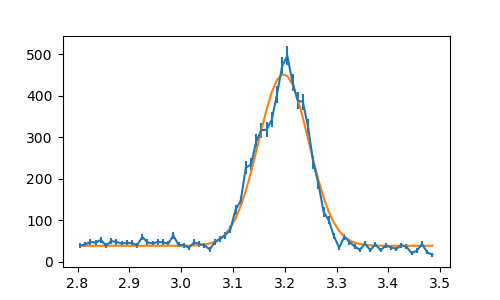

In [142]:
plt.figure(figsize=(5,3))
plt.errorbar(X1, Y1, yerr=np.sqrt(Y1))
plt.plot(X1, gauss_with_bg(X1, *popt))

In [144]:
np.average((Y1 - gauss_with_bg(X1, *popt))**2 / Y1)

3.8035875094607214

# Check 100882
This was done when the init guess was not obtained from data.
The fitting result was then not optimal.
Later in this section we put in a better initial guess and the result was good.

In [112]:
I_d_100882 = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=100882, EndWorkspaceIndex=100882)

In [113]:
Xbb = I_d_100882.readX(0)
Y = I_d_100882.readY(0)

In [114]:
X = (Xbb[1:] + Xbb[:-1])/2

<IPython.core.display.Javascript object>


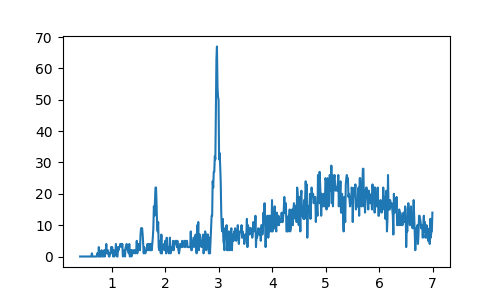

In [116]:
plt.figure(figsize=(5,3))
plt.plot(X,Y)
# plt.xlim(3, 3.5)

In [117]:
startindex, stopindex = np.where(X>2.8)[0][0], np.where(X<3.5)[0][-1]
X1 = X[startindex:stopindex]
Y1 = Y[startindex:stopindex]

<IPython.core.display.Javascript object>


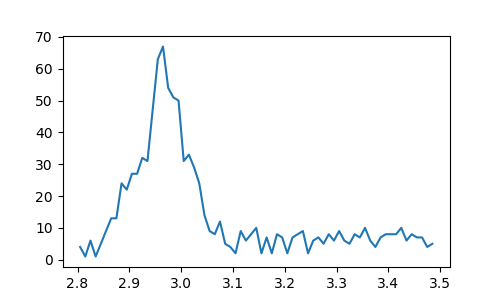

In [118]:
plt.figure(figsize=(5,3))
plt.plot(X1,Y1)

In [119]:
popt, pcov = sopt.curve_fit(gauss_with_bg, X1, Y1, p0=(400, 3.13, 0.05, 0))
print popt

[-22.10247946   3.30661817   0.15284577  24.91270788]


<IPython.core.display.Javascript object>


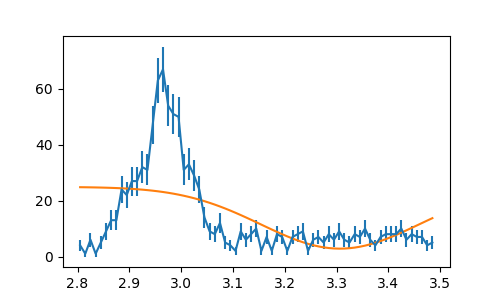

In [120]:
plt.figure(figsize=(5,3))
plt.errorbar(X1, Y1, yerr=np.sqrt(Y1))
plt.plot(X1, gauss_with_bg(X1, *popt))

In [121]:
popt, pcov = sopt.curve_fit(gauss_with_bg, X1, Y1, p0=(60, 3., 0.05, 0))
print popt

[  5.05073563e+01   2.96736415e+00   4.20948025e-02   6.33455700e+00]


<IPython.core.display.Javascript object>


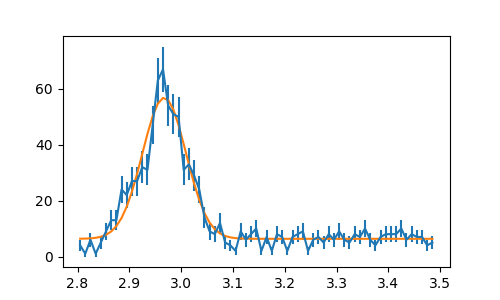

In [122]:
plt.figure(figsize=(5,3))
plt.errorbar(X1, Y1, yerr=np.sqrt(Y1))
plt.plot(X1, gauss_with_bg(X1, *popt))

In [125]:
X1[np.argmax(Y1)], np.max(Y1)

(2.9649999999999808, 67.0)

# Check aligned I(d)

In [145]:
t = msa.Load('./difc_cal.nxs')

In [146]:
t.getColumnNames()

['detid', 'difc', 'difa', 'tzero', 'tofmin', 'tofmax']

In [147]:
tzero = np.array(t.column('tzero'))

In [148]:
np.all(tzero==0)

True

In [149]:
for i, v in enumerate(newdifc):
    t.setCell('difc', i, v)
    continue

In [150]:
%%time
aligned = msa.AlignDetectors(InputWorkspace=ws, CalibrationWorkspace=t)

CPU times: user 21 s, sys: 27.8 s, total: 48.8 s
Wall time: 19.5 s


In [151]:
%%time
aligned = msa.CropWorkspace(InputWorkspace='aligned', XMin=0.4, XMax=7)

CPU times: user 38.7 s, sys: 41 s, total: 1min 19s
Wall time: 6.08 s


In [152]:
%%time
I_d = msa.Rebin(InputWorkspace=aligned, Params='0.4,0.0005,7')

CPU times: user 5.5 s, sys: 1.47 s, total: 6.97 s
Wall time: 5.92 s


In [153]:
I_d_pack_d23 = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=100352, EndWorkspaceIndex=101375)

<IPython.core.display.Javascript object>


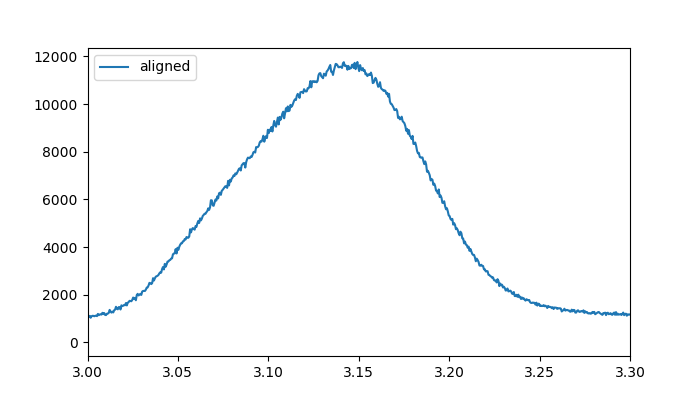

In [154]:
x_bb = I_d_pack_d23.readX(0); y = I_d_pack_d23.readY(0)
x = (x_bb[1:] + x_bb[:-1])/2
plt.figure(figsize=(7,4))
plt.plot(x,y, label='aligned')
plt.xlim(3,3.3)
plt.legend(loc='upper left')

In [155]:
I_d_100455 = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=100455, EndWorkspaceIndex=100455)

<IPython.core.display.Javascript object>


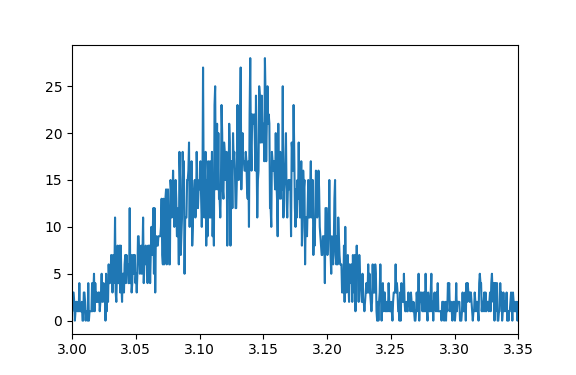

(3, 3.35)

In [156]:
plt.figure(figsize=(7,4))
Xbb = I_d_100455.readX(0)
plt.plot( (Xbb[:-1]+Xbb[1:])/2, I_d_100455.readY(0))
plt.xlim(3,3.35)